In [72]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from lmfit.models import LinearModel
import pandas as pd
from JensenTools import *
sns.set()

# My functions

In [73]:
# Takes a filename and data directory
# Returns the field, magnetic moment, error, and name (temperature) of the run
# field, moment, and error are returned as np arrays
# name is returned as a string
## Note that the name handling is hardcoded for how my lab conventionally names our files.
def getData(magrun, dataDir):
    name = magrun.split('_')[-1].split('.')[0]
    mass = magrun.split('_')[3]
    mass = mass.replace('P','.')
    mass = mass[:-2]
    measType = magrun.split('_')[-1].split('.')[0]
    
    f = open(dataDir + magrun)
    while f.readline().strip() != '[Data]':
        pass
    df = pd.read_csv(f)
    df.dropna(subset = ['Magnetic Field (Oe)','M. Std. Err. (emu)'],inplace = True)
    T = np.array(df['Temperature (K)'])
    H = np.array(df['Magnetic Field (Oe)'])
    E = np.array(df['M. Std. Err. (emu)'])
    Mom = np.array(df['Moment (emu)']) 
    return H, Mom, E, name

def getMass(filename):
    mass = filename.split('_')[3]
    mass = mass.replace('P','.')
    mass = mass[:-2]
    mass = float(mass)
    mass = mass/1000
    return mass

def getTemp(filename):
    temp = filename.split('_')[-1].split('.')[0][:-1]
    temp = float(temp)
    return temp

#Takes a list of moments (in emu), sample mass, and molecular weight
#Returns list of moments (in Bohr Magnetons)
def emuToBohr(emuM,mass,molweight):
    avo =6.0221409e+23 #part/mol
    bohr = 9.274e-21 #emu / Bohr magneton = erg/G/Bohrmag
    if (isinstance(emuM,list)):
        bohrM = []
        for i in M:
            bohrM.append(i/(mass/molweight*avo*bohr))
    else:
        bohrM = emuM/(mass/molweight*avo*bohr)
    return bohrM

#Takes in a list of magnetic field (in Oe)
#Returns a list of magnetic fields (in Tesla)
def oeToTesla(H):
    newH = H/10000
    return newH

# Load the M vs H data files
## Manually name the sample in the variable "comp"
## Manually enter the molecular weight (g/mol)
## Load the sample mass (grams) as read in by one of the data files' name

Molecular weight calculated by https://www.lenntech.com/calculators/molecular/molecular-weight-calculator.htm

In [74]:
dataDir = 'data/' #Where the measured data files are stored
runs = [] #A list of all the data file names
for i in os.listdir(dataDir):
    if i.endswith('.DAT'): #This was a safeguard against a situation arising at an earlier implementation of my code.
        runs.append(i)

comp = 'Sr2PrO4'
molweight = 380.15
mass = getMass(runs[0])
T = getTemp(runs[0])

# Order the files by temperature
This guarantees nicer plotting

In [75]:
temp = [] #The newly sorted list
for i in runs:
    temp.append(getTemp(i)) #this creates a list of just temperatures as read by the filename
   
temp = np.argsort([int(i) for i in temp]) #Sort by temperature
runs = [runs[i] for i in temp]

# Plot all runs and store data in dictionary 'data'
## H = Applied magnetic field, M = Magnetization, Err = Error on the Magnetization measurement

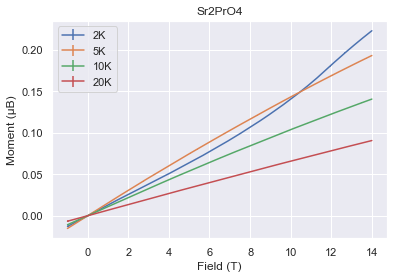

In [76]:
#This dictionary easily allows me to access the data from a specific run
## {'Temperature': [H,M,Err]} 
data = {}
plt.figure()
for i in runs:
    H, M, Err, name = getData(i,dataDir)
    M = emuToBohr(M,mass,molweight)
    H = oeToTesla(H)
    Err = emuToBohr(Err,mass,molweight)
    data[name] = [H,M,Err]
    plt.errorbar(H,M, yerr = Err, label = name)

plt.title(comp)
plt.ylabel('Moment (\N{GREEK SMALL LETTER MU}B)')
plt.xlabel('Field (T)')
plt.legend()
plt.show()

# Choose a run to fit for saturation magnetization.
## Usually the lowest temperature run

In [77]:
temp = '20K'
curRun = data[temp] #loading the data from my current run
H = curRun[0]
M = curRun[1]
Err = curRun[2]

# Choose your field range to fit over.
## The saturation magnetization is a linear fit and should be fitted within a reasonable magnetic field range that makes sense for the system.

In [78]:
fieldRange = [0,14]
newH = []
newM = []
newErr = []
for i in range(len(curRun[0])):
    if (H[i] >= fieldRange[0] and H[i] <= fieldRange[1]):
        newH.append(H[i])
        newM.append(M[i])
        newErr.append(Err[i])


# Create the linear model and fit to the data over the desired range.

In [79]:
linModel = LinearModel()
params = linModel.guess(newM, x = newH)
fitted = linModel.fit(newM, x = newH, weights = newErr)

# Create a full length line using the fitted parameters.

In [80]:
MLine = []
for i in H:
    MLine.append(fitted.params['slope'].value*i + fitted.params['intercept'].value)

# Plot the data and the fit

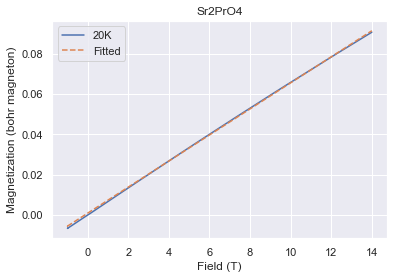

Saturation magnetization =  0.001 bohr magneton


In [81]:
plt.plot(H,M, label = temp)
plt.plot(H,MLine, linestyle = '--', label = 'Fitted')
plt.xlabel('Field (T)')
plt.ylabel('Magnetization (bohr magneton)')
plt.legend()
plt.title(comp)
plt.show()

print('Saturation magnetization =  {:.3f} bohr magneton'.format(fitted.params['intercept'].value))